# Diatomic Line List Tutorial

This is intended to show you how to use the linelisttools package to update a diatomic line list computed with the program Duo (https://github.com/Trovemaster/Duo) using MARVEL energies.

The process is as follows:
- Find the levels that occur in both the MARVEL and Duo datasets and match them up, taking the MARVEL energy as the final energy for the updated line list.
- Update the energies of "parity pairs". This means that, for example, if we have observational data for the a_3Pi, v=0, J=0 + state but not the - parity counterpart, we apply the same obs.-calc. energy shift from the known + parity state to the - parity state.
- Predict shifts based on the obs.-calc. trends. For diatomics, these trends are fit for each spin-orbit (Omega) component of each vibronic band. We do this in two ways: first we use linear regression to fill in the gaps between MARVEL energy levels, including filling in the band down to the theoretical lowest J value. Secondly we use the observed trends in the last few known obs.-calc. data points in each band to extrapolate an uncertainty beyond the maximum J in that band, up until the highest calculated J.
- Estimate uncertainties for the remaining calculated levels.

In [1]:
# General imports
import pandas as pd
import numpy as np

# This package
from linelisttools.concurrence import ExecutorType
from linelisttools.marvel import read_marvel_energies
from linelisttools.states import (
    ExoMolStatesHeader,
    match_states,
    read_exomol_states,
    shift_parity_pairs,
    predict_shifts,
    set_calc_states,
)
from linelisttools.format import SourceTag, output_data
from linelisttools.plot import get_vibrant_colors, plot_states_by_source_tag, plot_state_coverage, PlotType

%load_ext autoreload
%autoreload 2

In [2]:
# These pandas options may be useful for viewing the DataFrames containing the line list at each step of the way
pd.set_option("display.width", 320)
pd.set_option("display.max_columns", None)

First we need a header object to describe the Duo states file we are reading in. This uses the ExoMol format and works for diatomics and polyatomics.

In [3]:
header = ExoMolStatesHeader(
    unc=None,
    lifetime=None,
    parity=["parity_tot", "parity_rotless"],
    symmetry="state",
    vibrational_qn="v",
    other_qn=["Lambda", "Sigma", "Omega"],
    source_tag=None,
)
df_duo = read_exomol_states(r"./inputs/SO.states", exomol_states_header=header)
print(f"Number of Duo states: {len(df_duo)}")
print("Duo states: \n", df_duo)

Number of Duo states: 169836
Duo states: 
             id        energy  degeneracy    J parity_tot parity_rotless     state   v  Lambda  Sigma  Omega
0            1      0.000000           1    0          +              e    X3Sig-   0       0      0      0
1            2   1137.957487           1    0          +              e    X3Sig-   1       0      0      0
2            3   2263.236151           1    0          +              e    X3Sig-   2       0      0      0
3            4   3376.068879           1    0          +              e    X3Sig-   3       0      0      0
4            5   4476.082035           1    0          +              e    X3Sig-   4       0      0      0
...        ...           ...         ...  ...        ...            ...       ...  ..     ...    ...    ...
169831  183765  64286.448097         523  261          -              e    b1Sig+   5       0      0      0
169832  183766  64290.871986         523  261          -              e      A3Pi   9      -1

Next we need our MARVEL energies. This assumes the default format output by MARVEL where the first n columns represent the n quantum numbers used to identify each level, followed by an energy, uncertainty and degree column. The example data set below has an unrealistic degree of 1 for every level, but the energies and uncertainties are real values.

In [4]:
df_marvel = read_marvel_energies(r"./inputs/SO_MarvelEnergies.states",
                                 qn_list=["state", "v", "Omega", "parity_tot", "J"])
print("Marvel levels: \n", df_marvel)

Marvel levels: 
        state  v  Omega parity_tot   J        energy       unc  degree
0     X3Sig-  0      0          +   0      0.000000  0.017427       1
1     X3Sig-  0      0          -   1      1.000746  0.003836       1
2     X3Sig-  0      0          +   2      3.099899  0.003832       1
3     X3Sig-  0      0          -   3      6.412186  0.003818       1
4     X3Sig-  0      1          +   1     10.552025  0.003834       1
...      ... ..    ...        ...  ..           ...       ...     ...
1025  B3Sig-  1      1          +  12  42088.154460  0.050144       1
1026  B3Sig-  1      1          +  18  42185.613930  0.050144       1
1027  B3Sig-  1      1          +  20  42226.127720  0.053306       1
1028  B3Sig-  1      1          +  22  42270.291740  0.050000       1
1029  B3Sig-  1      1          +  24  42318.296920  0.050000       1

[1030 rows x 8 columns]


To match the states we simply call the match_states method on our Duo and MARVEL data. The qn_match_cols arguments specifies the quantum number columns to match on and can either be the full set or a subset of the quantum numbers used in the MARVEL data. When a subset is specified, it is possible for each MARVEL level to match with multiple Duo levels. When this happens, the matching determines which of the multiple matches has the closest energy and returns that level as the match.

In [5]:
df_match = match_states(
    states_calc=df_duo,
    states_obs=df_marvel,
    qn_match_cols=["J", "parity_tot", "state", "v", "Omega"],
    match_source_tag=SourceTag.MARVELISED,
    states_header=header,
)
print(df_match)

STATES MATCHED: 
          id   energy_calc  degeneracy   J parity_tot parity_rotless   state  v  Lambda  Sigma  Omega    energy_obs       unc  degree
0         1      0.000000           1   0          +              e  X3Sig-  0       0      0      0      0.000000  0.017427       1
1         2   1137.957487           1   0          +              e  X3Sig-  1       0      0      0   1137.956142  0.019190       1
2        11  10478.344891           1   0          +              e  b1Sig+  0       0      0      0  10478.344840  0.003832       1
3        13  11532.596408           1   0          +              e  b1Sig+  1       0      0      0  11532.601810  0.003849       1
4        15  12572.442590           1   0          +              e  b1Sig+  2       0      0      0  12572.437000  0.003867       1
...     ...           ...         ...  ..        ...            ...     ... ..     ...    ...    ...           ...       ...     ...
1025  52633   3155.958551         135  67          

We can get some quick stats on the number of MARVELISED energy levels, the mean and standard deviation of the absolute obs.-calc. values and their RMS.

In [6]:
df_match_check = df_match.loc[df_match["source_tag"] == SourceTag.MARVELISED]
print(f"Number of Marvel states: {len(df_match_check)}")
print(
    f"Absolute mean Obs.-Calc.: {df_match_check['energy_dif'].abs().mean()},"
    f" Std.Dev.: {df_match_check['energy_dif'].abs().std()}"
)
rms_check = df_match_check.loc[~df_match_check["energy_dif"].isna(), "energy_dif"]
print("RMS: ", np.sqrt(sum(rms_check ** 2) / len(rms_check)))
del rms_check

Number of Marvel states: 1030
Absolute mean Obs.-Calc.: 0.05928923722337414, Std.Dev.: 0.12398224657788552
RMS:  0.13737498766512662


Below is a handy way to check how your MARVEL/Duo states are matching up. Plotly is useful for this as it renders in HTML and allows for custom data to be displayed when mousing-over the graph. In this case we display the quantum number assignment on mouse-over. This is helpful to check why some states are matching up poorly - perhaps two states have the same absolute obs.-calc. value? In that example they would likely be incorrectly labelled (swapped) and matching up with each other. In that case, consider changing the MARVEL or Duo labelling.

You can skip this if you do not have plotly installed, but it is very helpful the first time you match your MARVEL and Duo states to check they are behaving as expected.

In [7]:
import plotly.graph_objs as go
import plotly.io as pio

state_colour = get_vibrant_colors(10)
pio.renderers.default = "browser"
df_temp = df_match_check.loc[~df_match_check["energy_obs"].isna()].sort_values(
    by=["energy_obs"]
)
df_temp["label"] = df_temp.apply(
    lambda x: f"{x['state']}, v={x['v']}, Omega={x['Omega']}, J={x['J']} {x['parity_tot']}<br>",
    axis=1,
)
fig = go.Figure()
for state_idx, state_val in enumerate(df_temp["state"].unique()):
    fig.add_trace(
        go.Scatter(
            x=df_temp.loc[df_temp["state"] == state_val, "energy_obs"],
            y=df_temp.loc[
                df_temp["state"] == state_val, "energy_dif"
            ].abs(),
            mode="markers",
            marker=dict(color=state_colour[state_idx - 1]),
            hovertext=df_temp.loc[
                df_temp["state"] == state_val, "label"
            ],
            name=state_val,
        )
    )
fig.update_layout(
    title="SO Marvel - Duo Energy Comparison",
    xaxis=dict(title="Energy (cm<sup>-1</sup>)"),
    yaxis=dict(title="Obs.-Calc. (cm<sup>-1</sup>)", type="log"),
)
fig.show()

fig = go.Figure()
for state_idx, state_val in enumerate(df_temp["state"].unique()):
    fig.add_trace(
        go.Scatter(
            x=df_temp.loc[df_temp["state"] == state_val, "J"],
            y=df_temp.loc[
                df_temp["state"] == state_val, "energy_dif"
            ].abs(),
            mode="markers",
            marker=dict(color=state_colour[state_idx - 1]),
            hovertext=df_temp.loc[
                df_temp["state"] == state_val, "label"
            ],
            name=state_val,
        )
    )
fig.update_layout(
    title="SO Marvel - Duo J Comparison",
    xaxis=dict(title="J"),
    yaxis=dict(title="Obs.-Calc. (cm<sup>-1</sup>)", type="log"),
)
fig.show()

The parity pairs corrections aim to preserve the calculated parity splitting in states with Lambda-doubling, i.e.: for states with the same values of J in the same spin-orbit components of the same vibronic states but with differing parities. To make this easier to achieve, we transform the Omega value we have to the absolute value/projection of Omega. Otherwise, the + parity states of the Omega=1 component of a 3Pi state would not be grouped with their corresponding - parity states, as their Omega=-1.

In [8]:
df_match["Omega_fit"] = df_match.apply(
    lambda x: x["Omega"] * -1 if x["parity_tot"] == "-" else x["Omega"], axis=1
)

In [9]:
df_match = shift_parity_pairs(
    states=df_match,
    states_header=header,
    shift_table_qn_cols=["state", "v", "Omega_fit", "J"],
)
print(
    "States with PS_1 parity pair Predicted Shifts: \n",
    df_match.loc[df_match["source_tag"] == SourceTag.PS_PARITY_PAIR],
)

States with PS_1 parity pair Predicted Shifts: 
             id   energy_calc  degeneracy   J parity_tot parity_rotless   state  v  Lambda  Sigma  Omega  energy_obs       unc  degree  energy_dif source_tag  energy_final  Omega_fit
2371    1416.0  38099.450743         5.0   2          -              f    A3Pi  0    -1.0    0.0     -1         NaN  0.150049     NaN         NaN       PS_1  38099.382152          1
2381    1426.0  38517.023104         5.0   2          -              f    A3Pi  1    -1.0    0.0     -1         NaN  0.200037     NaN         NaN       PS_1  38516.682557          1
2735    1798.0  38103.060534         7.0   3          +              f    A3Pi  0     1.0    0.0      1         NaN  0.150049     NaN         NaN       PS_1  38102.953412          1
2746    1809.0  38520.528182         7.0   3          +              f    A3Pi  1     1.0    0.0      1         NaN  0.200036     NaN         NaN       PS_1  38520.199222          1
3776    2905.0   3399.271261         9.0 

For the predicted shifts we fit to each state/v/Omega combination, i.e.: each spin-orbit component of each vibronic band.

Comment out the plot_states line to plot all fits, and try playing around with j_segment_threshold_size to see how that changes the fits.

TEST1 range(0, 12)
TEST2 [2 3 4 5]
TEST3 [2 3 4 5]
TEST4 [2 3 4 5]
TEST5 [2 3 4 5]
TEST6 [2 3 4 5]
TEST1 range(0, 12)
TEST2 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34]
TEST3 [ 2  3  4  5  6  7  8  9 10 11]
TEST4 [ 2  3  4  5  6  7  8  9 10 11]
TEST5 [ 2  3  4  5  6  7  8  9 10 11]
TEST6 [ 2  3  4  5  6  7  8  9 10 11]


100%|██████████| 20/20 [00:00<00:00, 211.47it/s]

TEST1 range(10, 21)
TEST2 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34]
TEST3 [10 11 12 13 14 16 17 18 19 20]
TEST4 [10 11 12 13 14 16 17 18 19 20]
TEST5 [10 11 12 13 14 16 17 18 19 20]
TEST6 [10 11 12 13 14 16 17 18 19 20]
TEST1 range(0, 12)
TEST2 [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34]
TEST3 [ 2  3  4  5  6  7  8  9 10 11]
TEST4 [ 2  3  4  5  6  7  8  9 10 11]
TEST5 [ 2  3  4  5  6  7  8  9 10 11]
TEST6 [ 2  3  4  5  6  7  8  9 10 11]
TEST1 range(0, 36)
TEST2 [ 2  6  8 10 12 16 18 22 24 26]
TEST3 [ 2  6  8 10 12 16 18 22 24 26]
TEST4 [ 2  6  8 10 12 16 18 22 24 26]
TEST5 [ 2  6  8 10 12 16 18 22 24 26]
TEST6 [ 2  6  8 10 12 16 18 22 24 26]
TEST1 range(0, 30)
TEST2 [ 4  5  7  8  9 10 11 12 13 15 18 20 21 22 23 24 25]
TEST3 [ 4  5  7  8  9 10 11 12 13 15 18 20 21 22 23 24 25]
TEST4 [ 4  5  7  8  9 10 11 12 13 15 18 20 21 22 23 24 25]
TEST5 [ 4  8  9 10 11 12 13 15 18 20 21

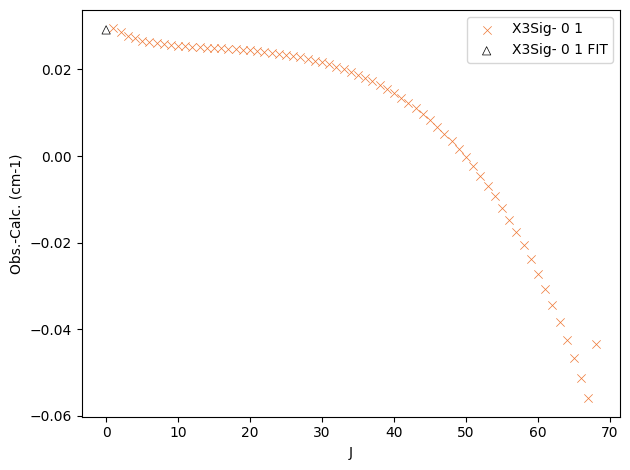

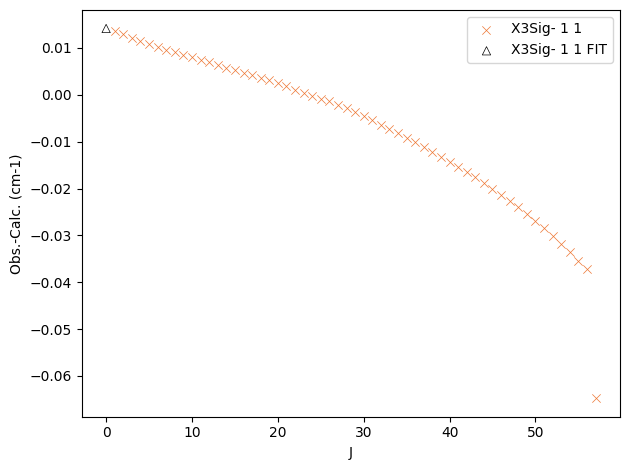

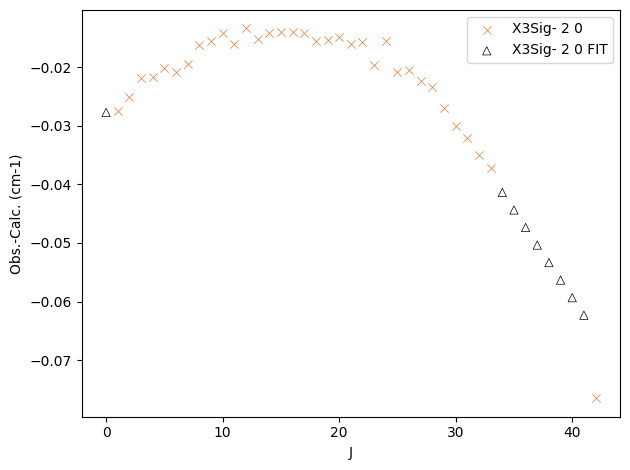

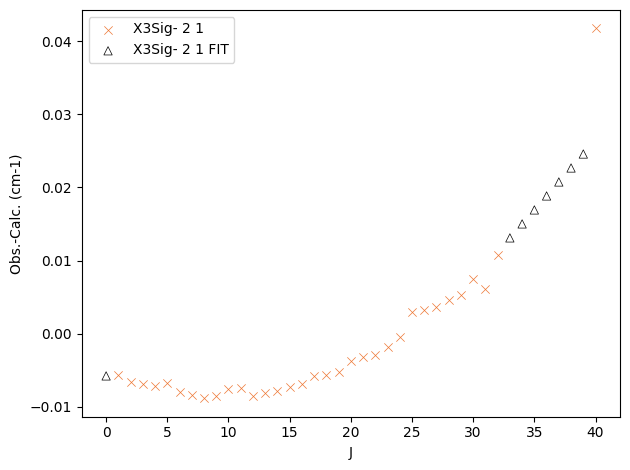

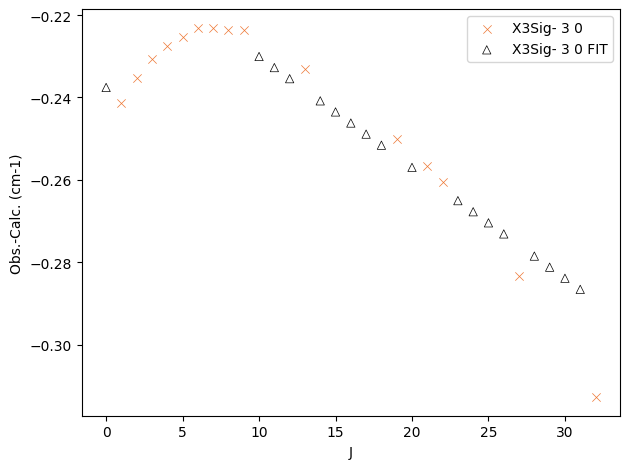

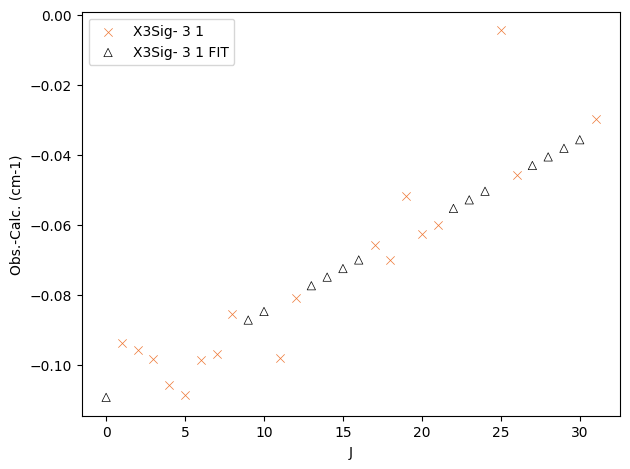

PS_2: 
             id   energy_calc  degeneracy   J parity_tot parity_rotless   state  v  Lambda  Sigma  Omega  energy_obs       unc  degree  energy_dif source_tag  energy_final  Omega_fit
2          3.0   2263.236151         1.0   0          +              e  X3Sig-  2     0.0    0.0      0         NaN  0.008311     NaN         NaN       PS_2   2263.208460          0
3          4.0   3376.068879         1.0   0          +              e  X3Sig-  3     0.0    0.0      0         NaN  0.020858     NaN         NaN       PS_2   3375.831300          0
117      118.0  41995.445534         1.0   0          +              e  B3Sig-  1     0.0    0.0      0         NaN  0.305862     NaN         NaN       PS_2  41995.188084          0
351      352.0  38097.044023         3.0   1          +              f    A3Pi  0     1.0    0.0      1         NaN  0.167036     NaN         NaN       PS_2  38096.919031          1
358      359.0  38514.686206         3.0   1          +              f    A3Pi  1 

In [17]:
df_match = predict_shifts(
    states_matched=df_match,
    fit_qn_list=["state", "v", "Omega_fit"],
    states_header=header,
    j_segment_threshold_size=10,
    show_plot=True,
    plot_states=["X3Sig-"],
    executor_type=ExecutorType.THREADS,
    n_workers=1,
)
print(
    "States with linear regression (PS_2) & extrapolation (PS_3) Predicted Shifts: \n",
    df_match.loc[df_match["source_tag"].isin([SourceTag.PS_LINEAR_REGRESSION, SourceTag.PS_EXTRAPOLATION])],
)

The last thing to do is estimate an uncertainty for the calculated states. This takes a global base uncertainty for all calculated levels and then extrapolates from that base based on the v and J assignments of the levels. This base is twice the standard deviation of the absolute obs.-calc. values by default, but you can try using the mean absolute obs.-calc. instead and pass that to the base_calc_unc argument.

In [12]:
df_match = set_calc_states(
    states=df_match,
    states_header=header,
    unc_j_factor=0.0001,
    unc_v_factor=0.05,
)
print("States with predicted Calculated (Ca) Unc.: \n", df_match)

States with predicted Calculated (Ca) Unc.: 
               id   energy_calc  degeneracy    J parity_tot parity_rotless     state   v  Lambda  Sigma  Omega   energy_obs       unc  degree  energy_dif source_tag  energy_final  Omega_fit
0            1.0      0.000000         1.0    0          +              e    X3Sig-   0     0.0    0.0      0     0.000000  0.017427     1.0    0.000000         Ma      0.000000          0
1            2.0   1137.957487         1.0    0          +              e    X3Sig-   1     0.0    0.0      0  1137.956142  0.019190     1.0   -0.001345         Ma   1137.956142          0
2            3.0   2263.236151         1.0    0          +              e    X3Sig-   2     0.0    0.0      0          NaN  0.008311     NaN         NaN       PS_2   2263.208460          0
3            4.0   3376.068879         1.0    0          +              e    X3Sig-   3     0.0    0.0      0          NaN  0.020858     NaN         NaN       PS_2   3375.831300          0
4        

The new line list can be output using the column formats specified for the ExoMol standard as below.

In [34]:
out_cols = ["id", "energy_final", "degeneracy", "J", "unc", "parity_tot", "state", "v",
            "Lambda", "Sigma", "Omega", "source_tag"]
out_col_format_list = ["i12", "f14.7", "i6", "f6.1", "e14.7", "a2", "a10", "i3", "i3", "f5.1", "f5.1", "a3"]
df_states = df_match[out_cols]
df_states = df_states.rename(columns={"energy_final": "energy"})

output_data(
    df_states,
    filename=r"./outputs/32S-16O.states",
    fortran_format_list=out_col_format_list,
)

# Plotting

There are currently two in-built plots in this package. The first plots the contents of the states file, colour coded by their source_tag. This can be restricted to a subset of the possible source_tag values and to a subset of the present electronic states.

This does currently assume the states file contains a total parity column.

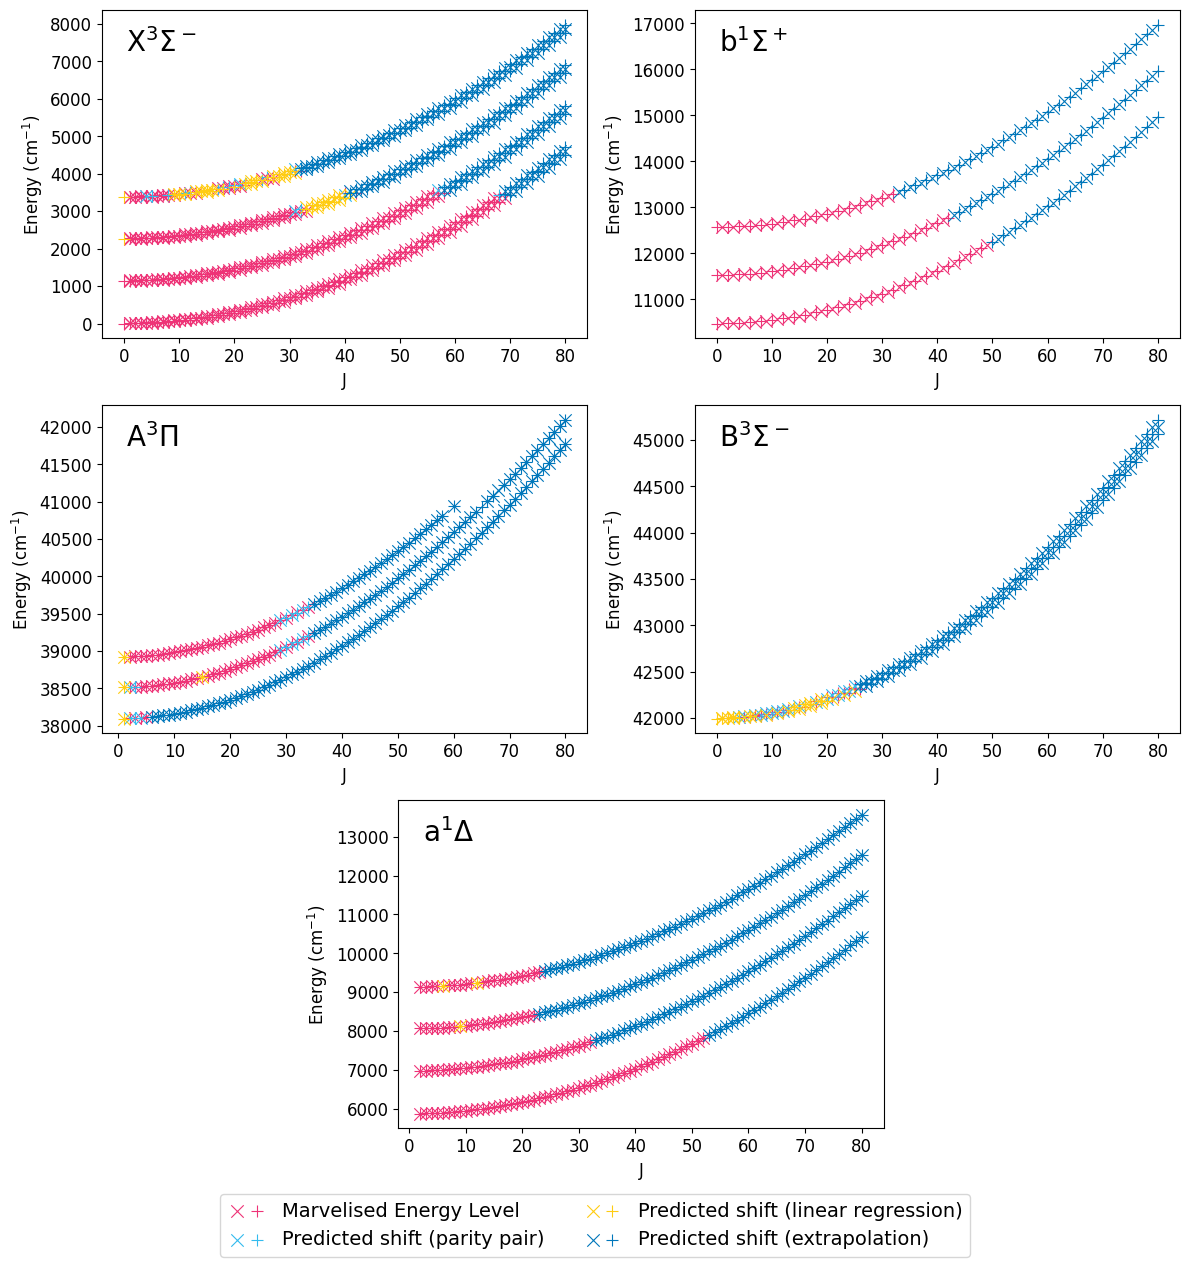

In [174]:
plot_states_by_source_tag(
    states=df_states,
    show=True,
    out_file=r"./outputs/32S-160_source_tag.png",
    # energy_cutoff=40000,
    j_cutoff=80,
    # plot_state_list=["X3Sig-", "A3Pi"],
    # plot_state_list=["X3Sig-"],
    plot_state_list=["X3Sig-", "b1Sig+", "A3Pi", "B3Sig-", "a1Delta"],
    plot_source_list=[
        SourceTag.MARVELISED,
        SourceTag.PS_PARITY_PAIR,
        SourceTag.PS_LINEAR_REGRESSION,
        SourceTag.PS_EXTRAPOLATION,
        # SourceTag.CALCULATED
    ],
)

The second plot shows the level coverage for a subset of or all the electronic states in the states file. This can be formatted as a violin plot (PlotType.VIOLIN) or event plot (PlotType.EVENT) by changing the value passed to plot_type.

The states appear in the same left-to-right order as the state_list argument. Alternatively, a dictionary mapping each state to an electron configuration can be passed to the state_configuration_dict argument to group the electronic states by configuration. When the electron_configurations argument is also provided, the electronic configurations will appear in the same left-to-right order as the list argument.

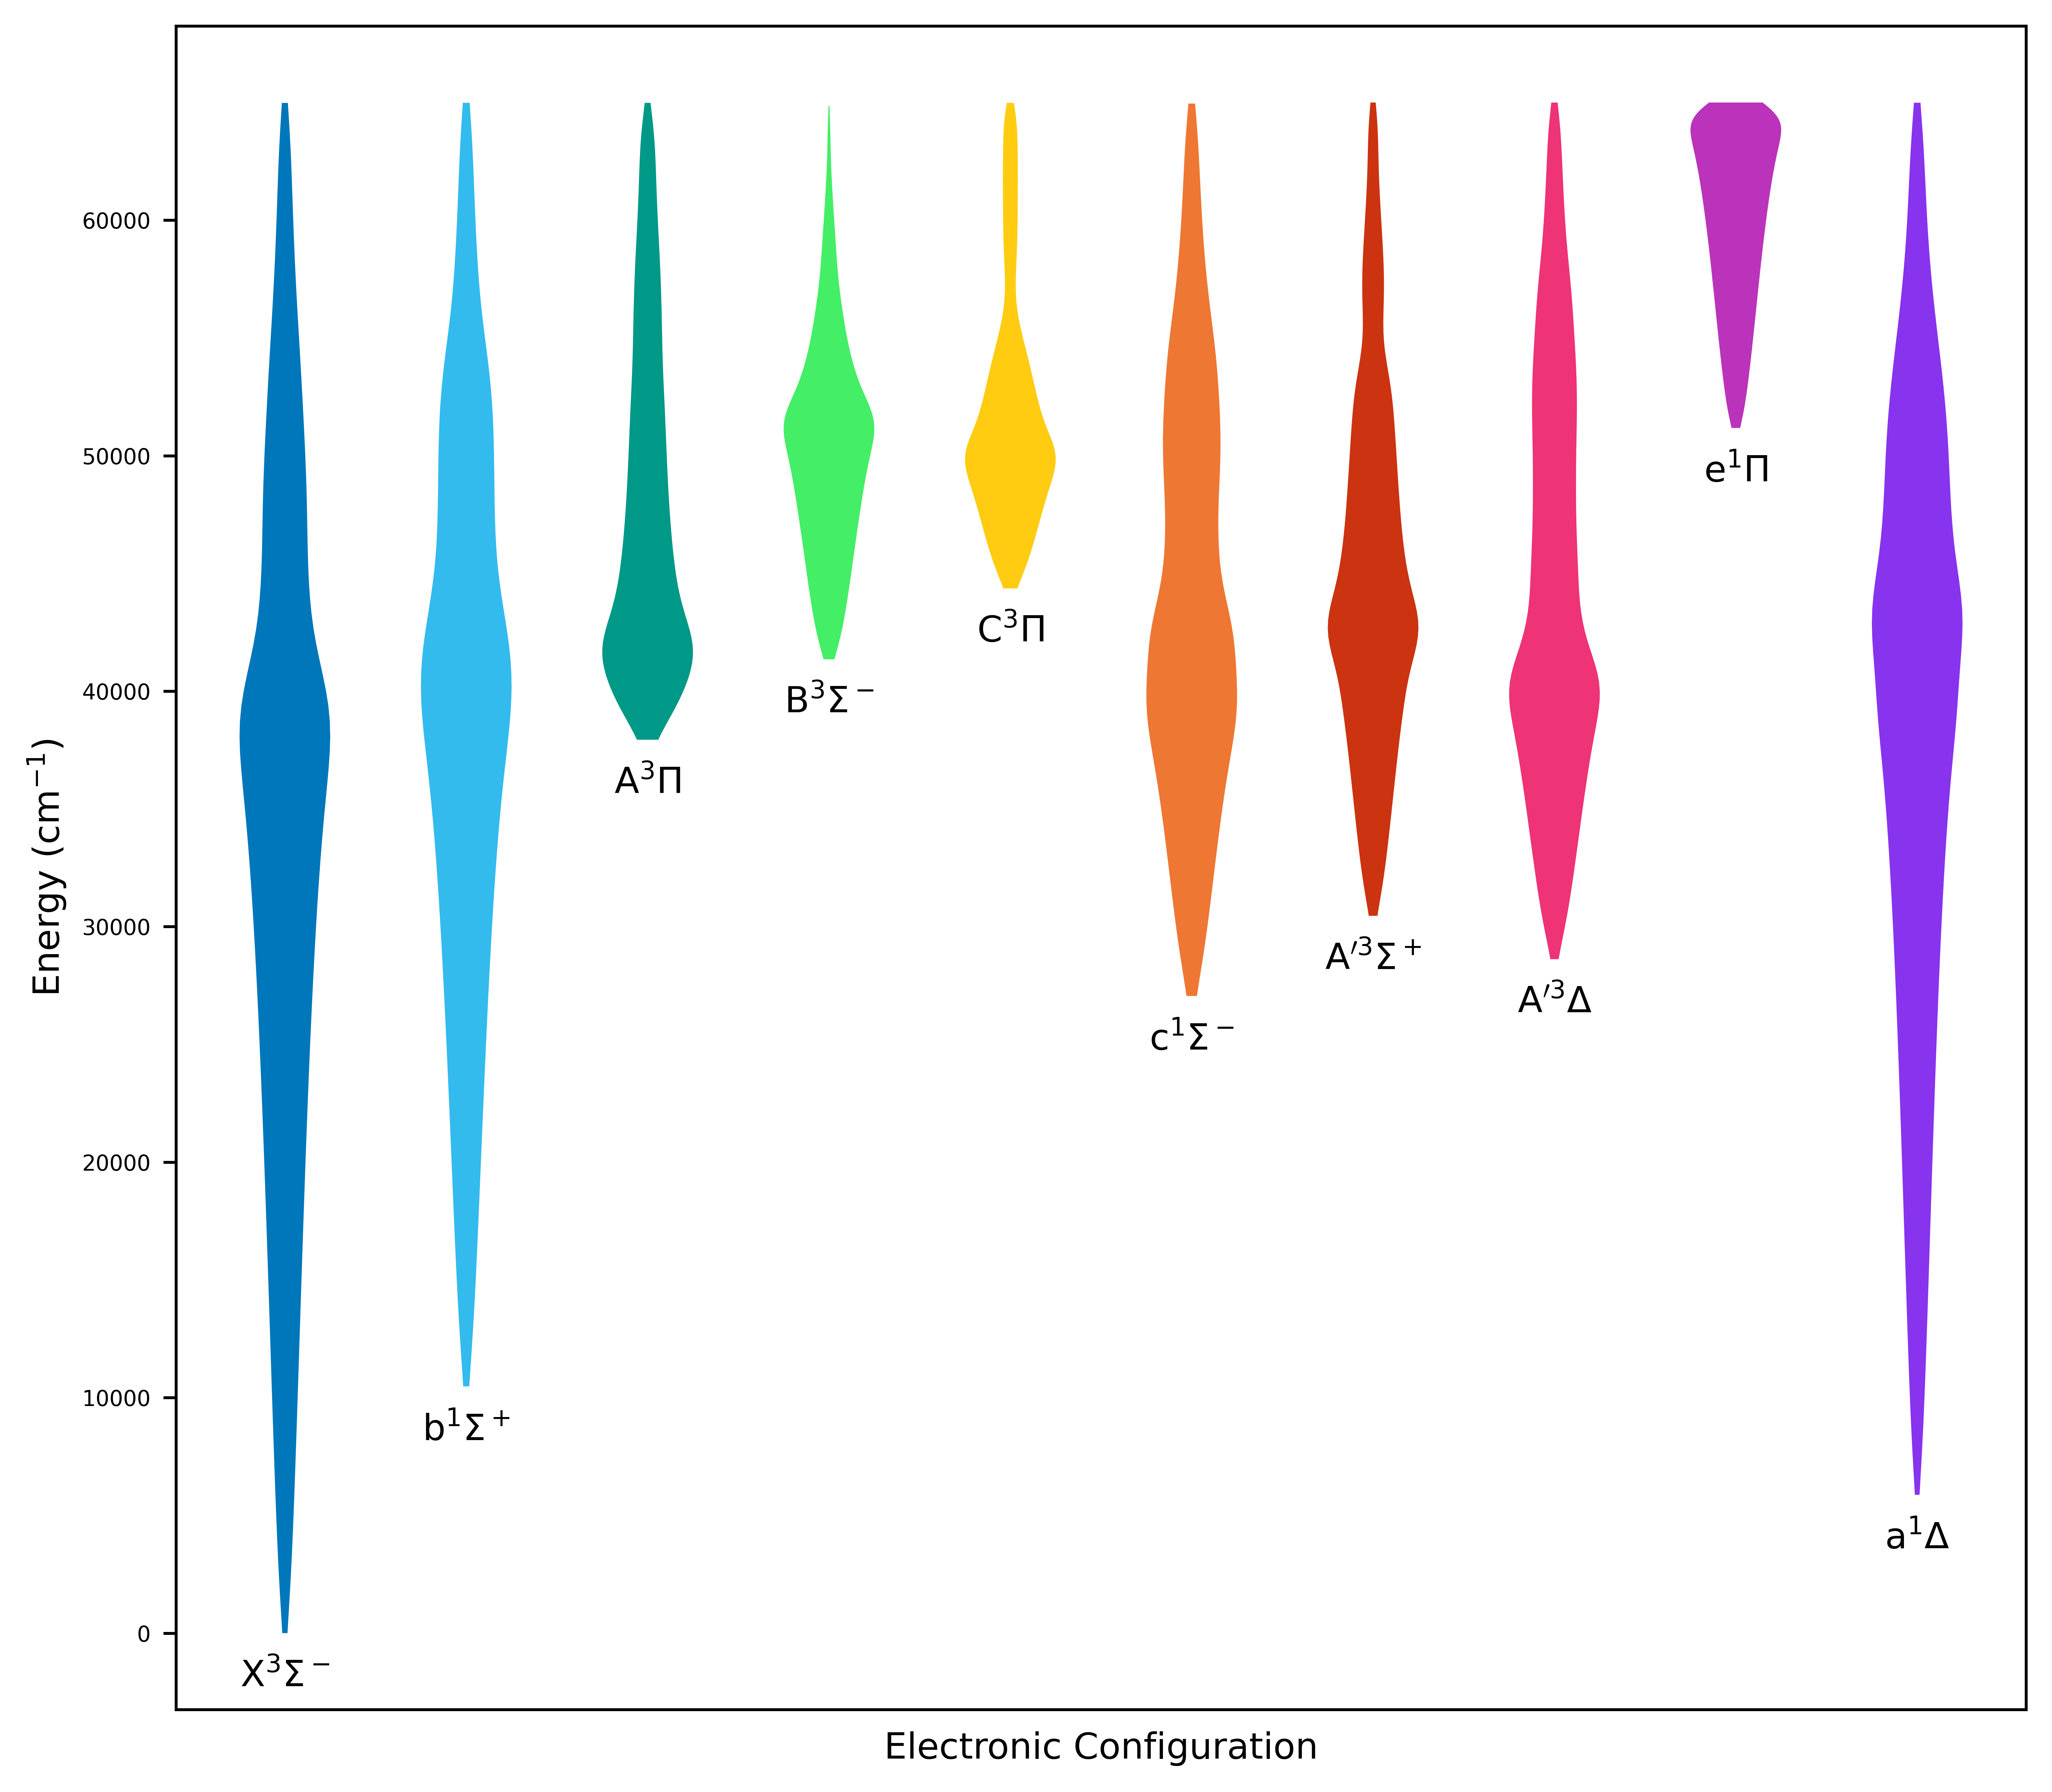

In [35]:
plot_state_coverage(
    energies=df_states,
    # state_list=["X3Sig-", "A3Pi"],
    state_list=df_states["state"].unique(),
    show=True,
    # out_file=r"./outputs/32S-160_state_coverage.png",
    plot_type=PlotType.VIOLIN,
)

An example of how to use this plot type with electronic configurations is shown below. The configurations are dummies, as I don't know what they should be for SO.

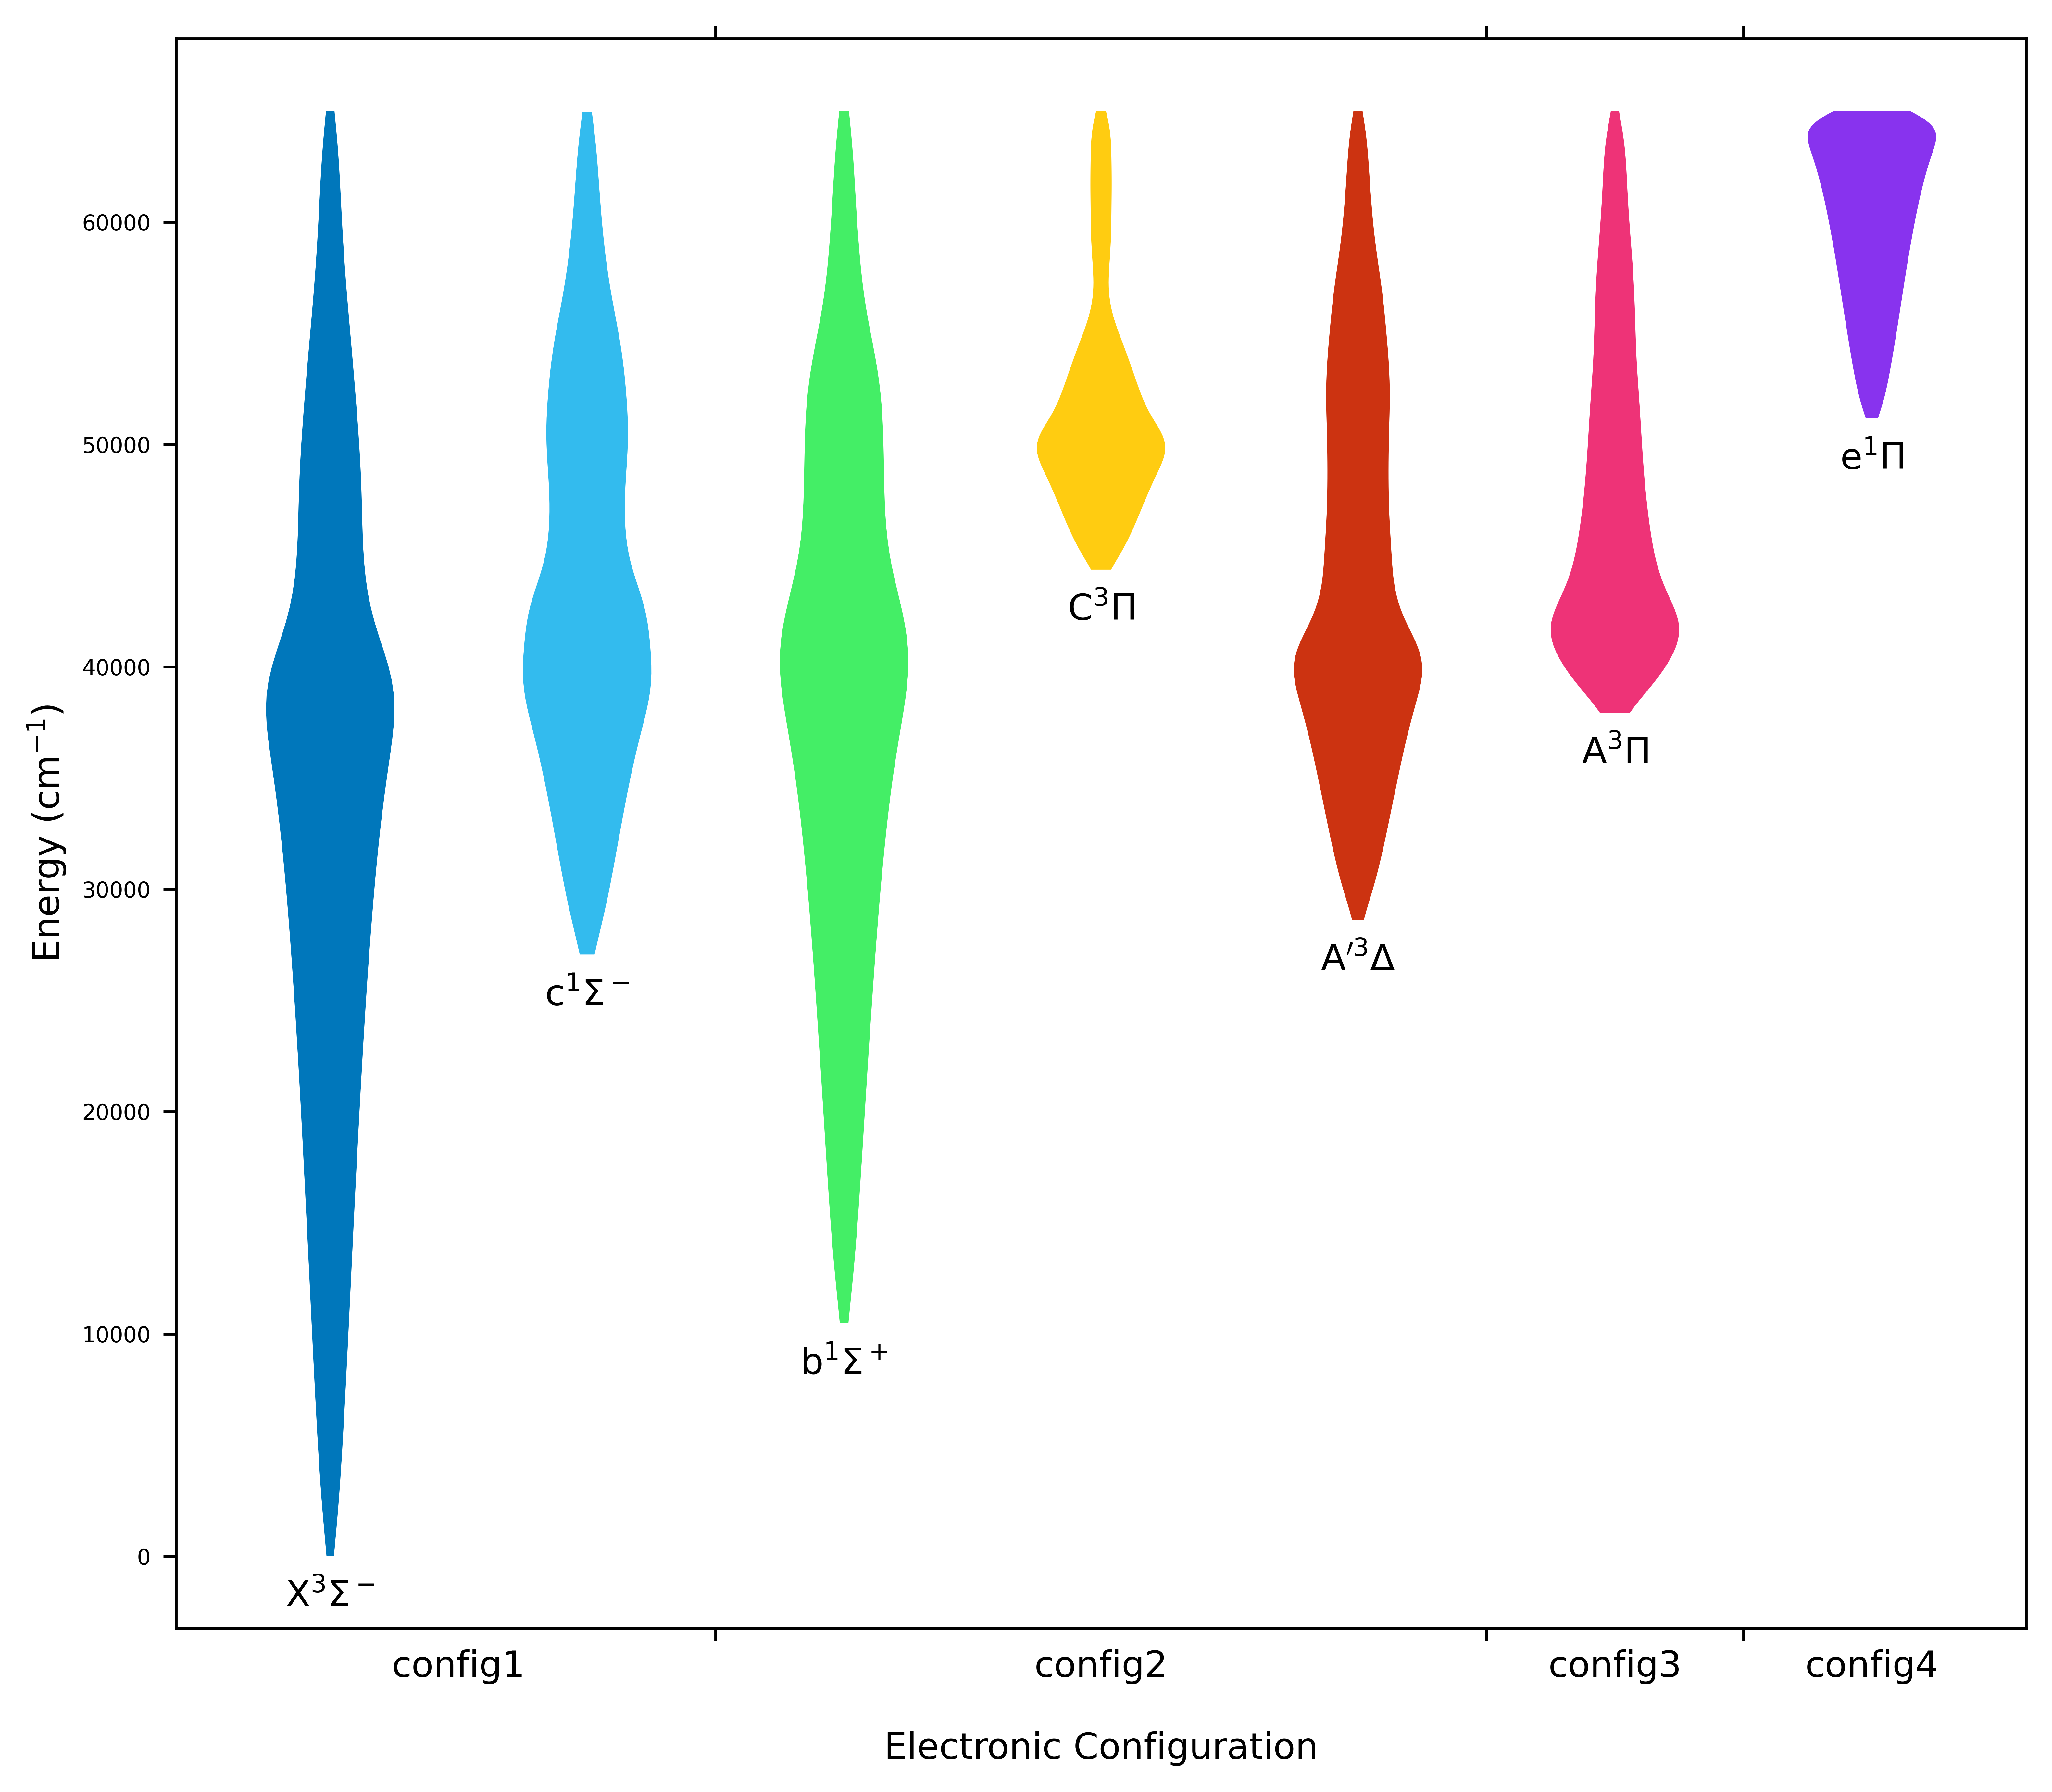

In [36]:
plot_state_coverage(
    energies=df_states,
    state_configuration_dict={
        "X3Sig-": "config1",
        "b1Sig+": "config2",
        "c1Sig-": "config1",
        "A3Pi": "config3",
        "C3Pi": "config2",
        "Ap3Delta": "config2",
        "e1Pi": "config4"
    },
    electron_configurations=["config1", "config2", "config3", "config4"],
    show=True,
    # out_file=r"./outputs/32S-160_state_coverage.png",
    plot_type=PlotType.VIOLIN,
)